In [6]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using Catalyst, DifferentialEquations, Plots, DataFrames

  Activating project at `~/Code/intro_julia_project`


In [ ]:
# functions 
vimp(et, vt, s0, Kt)           = (et * vt * (s0) / ((Kt) + (s0))) 
nucat(em, vm, si, Km)          = (em * vm * (si) / ((Km) + (si))) 

tx(wx, a, thetax)              = wx * a / (thetax + a)
tx_q(wq, a, thetax, Kq, nq, q) = ((wq ) * a / ((thetax ) + a)) / (1 + (q / (Kq )) ^ nq)

gamma(gmax, a, Kgamma)            = (gmax) * a / ((Kgamma ) + a)
tlr(gmax, a, Kgamma, nx, cx)  = ((gamma(gmax, a, Kgamma) / nx) * cx) 

ttrate(gmax, a, Kgamma, cr, ct, cm, cq) = ((cr + ct + cm + cq)*gamma(gmax, a, Kgamma))
lam(gmax, a, Kgamma, cr, ct, cm, cq, mass)    = ttrate(gmax, a, Kgamma, cr, ct, cm, cq)/mass

In [ ]:
# model definition
growth_model = @reaction_network begin 

    vimp(et, vt, s0, Kt),                               ∅ => si
    nucat(em, vm, si, Km),                              si => ∅
    nucat(em, vm, si, Km) * ns,                         ∅ => a
    ttrate(gmax, a, Kgamma, cr, ct, cm, cq),            a => ∅

    # transcription 
    tx(we, a, thetax),                                  ∅ => mm
    tx(we, a, thetax),                                  ∅ => mt
    tx_q(wq, a, thetax, Kq, nq, q),                     ∅ => mq
    tx(wr, a, thetar),                                  ∅ => mr

    # translation
    tlr(gmax, a, Kgamma, nx, cm),                       cm => r + em + mm
    tlr(gmax, a, Kgamma, nx, ct),                       ct => r + et + mt
    tlr(gmax, a, Kgamma, nx, cq),                       cq => r + q + mq
    tlr(gmax, a, Kgamma, nr, cr),                       cr => r + r + mr

    # reactions that follow mass action kinetics can use -->
    # ribosome binding and unbinding
    (kb, ku),                                           (mm + r, mt + r, mq + r, mr + r) <--> (cm, ct, cq, cr)
    
    # degradation
    dm,                                                 (mm, mt, mq, mr) --> ∅
    
    # dilution
    lam(gmax, a, Kgamma, cr, ct, cm, cq, Mref),         (a, si, mm, mt, mq, mr, cm, ct, cq, cr, em, et, q, r) --> ∅


end;

In [92]:
params = Dict(
    :dm => 0.1,
    :kb => 1,
    :ku => 1.0,
    :thetar => 426.8693338968694,
    :s0 => 1e4,
    :gmax => 1260.0,
    :thetax => 4.379733394834643,
    :Kt => 1.0e3,
    :Mref => 1.0e8,
    :we => 4.139172187824451,
    :Km => 1.0e3,
    :vm => 5800.0,
    :nx => 300.0,
    :Kq => 1.522190403737490e+05,
    :vt => 726.0,
    :wr => 929.9678874564831,
    :wq => 948.9349882947897,
    :nq => 4,
    :nr => 7549.0,
    :ns => 0.5,
    :Kgamma => 7,
)

u0 = Dict(:mt => 0.0, :mm => 0.0, :mq => 0.0, :mr => 0.0,
          :ct => 0.0, :cm => 0.0, :cq => 0.0, :cr => 0.0,
          :et => 0.0, :em => 0.0, :q => 0.0, :r => 10.0,
          :si => 0.0, :a => 1000.0)

tspan = (0.0, 1e9)

(0.0, 1.0e9)

In [93]:
prob = ODEProblem(growth_model, u0, tspan, params)
sol = solve(prob, Rodas5()); # a semicolon suppresses output

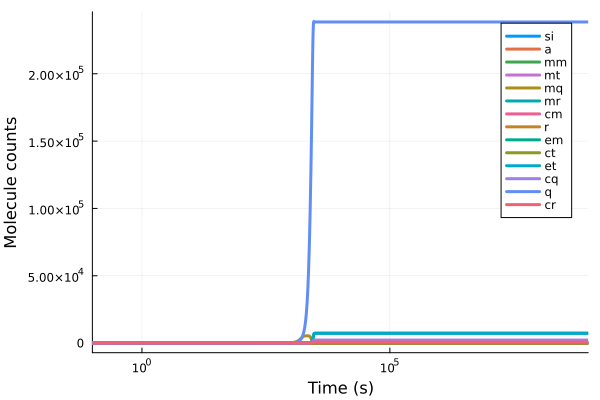

In [94]:
plot(sol[2:end], lw=3, xlabel="Time (s)", ylabel="Molecule counts")
plot!(xscale=:log10)
xlims!(1e-1, 1e9)

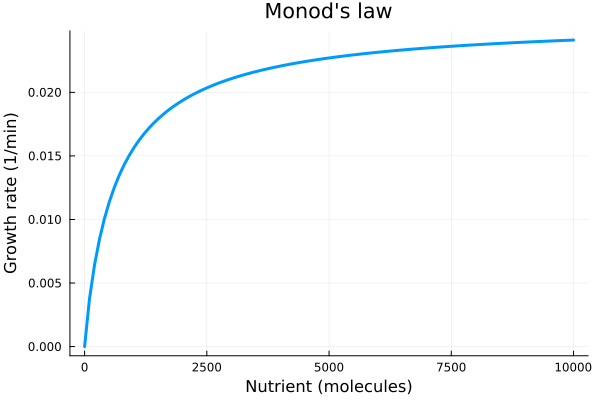

In [95]:
nutrient = range(0, 1e4, 100) # values of s0 to simulate
growth_rate = [] # to store growth rates
params_new = deepcopy(params) # make a copy of params to modify s0 so we don't change the original params, remember to use params_for_sim to convert back to list

# for loop to simulate for each nutrient value
for s0_val in nutrient
    params_new[:s0] = s0_val
    prob = ODEProblem(growth_model, u0, tspan, params_new)
    sol = solve(prob, Rodas5())
    df = DataFrame(sol)
    final_a = df[end, "a(t)"]
    final_cr = df[end, "cr(t)"]
    final_ct = df[end, "ct(t)"]
    final_cm = df[end, "cm(t)"]
    final_cq = df[end, "cq(t)"]
    growth = lam(params_new[:gmax], final_a, params_new[:Kgamma], final_cr, final_ct, final_cm, final_cq, params_new[:Mref])
    push!(growth_rate, growth)
end

# plot the results 
plot(nutrient, growth_rate, lw=3, xlabel="Nutrient (molecules)", ylabel="Growth rate (1/min)", title="Monod's law", legend=false)

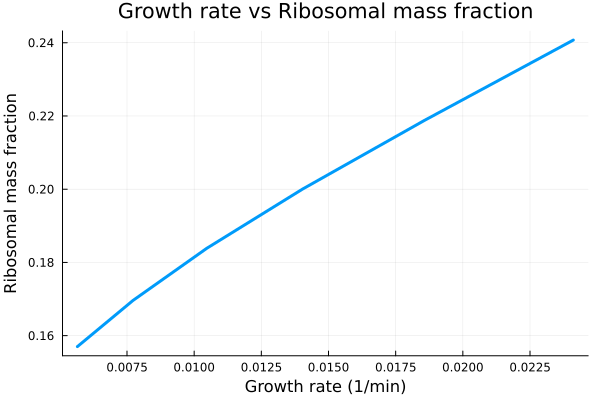

In [96]:
calc_rmf(r, cr, ct, cm, cq, nr, Mref) = nr * (r + cr + ct + cm + cq) / Mref

ns_arr2 = [0.08,0.11541599,0.16651064,0.24022489,0.3466,0.5] # ns values

growth_rate2 = []
rmf = []
# for loop to simulate for each ns value
for ns_val in ns_arr2
    params_new[:ns] = ns_val
    prob = ODEProblem(growth_model, u0, tspan, params_new)
    sol = solve(prob, Rodas5())
    df = DataFrame(sol)
    final_a = df[end, "a(t)"]
    final_cr = df[end, "cr(t)"]
    final_ct = df[end, "ct(t)"]
    final_cm = df[end, "cm(t)"]
    final_cq = df[end, "cq(t)"]
    growth = lam(params_new[:gmax], final_a, params_new[:Kgamma], final_cr, final_ct, final_cm, final_cq, params_new[:Mref])
    
    final_r = df[end, "r(t)"]
    rmf_val = calc_rmf(final_r, final_cr, final_ct, final_cm, final_cq, params_new[:nr], params_new[:Mref])
    push!(growth_rate2, growth)
    push!(rmf, rmf_val)
end

# plot the results 
plot(growth_rate2, rmf, lw=3, ylabel="Ribosomal mass fraction", xlabel="Growth rate (1/min)", title="Growth rate vs Ribosomal mass fraction", legend=false)

### Antibiotic model

In [97]:
# new function
zm(cx, abx, kcm) = cx * abx * kcm

# new parameters for abx model
params_abx = deepcopy(params)
params_abx[:abx] = 0
params_abx[:kcm] = 0.005990373118888

# new initial conditions
u0_abx = deepcopy(u0)
u0_abx[:zmm] = 0.0
u0_abx[:zmr] = 0.0
u0_abx[:zmt] = 0.0
u0_abx[:zmq] = 0.0

0.0

In [ ]:
# abx model definition
abx_growth_model = @reaction_network begin 

    vimp(et, vt, s0, Kt),                               ∅ => si
    nucat(em, vm, si, Km),                              si => ∅
    nucat(em, vm, si, Km) * ns,                         ∅ => a
    ttrate(gmax, a, Kgamma, cr, ct, cm, cq),            a => ∅

    # transcription 
    tx(we, a, thetax),                                  ∅ => mm
    tx(we, a, thetax),                                  ∅ => mt
    tx_q(wq, a, thetax, Kq, nq, q),                     ∅ => mq
    tx(wr, a, thetar),                                  ∅ => mr

    # translation
    tlr(gmax, a, Kgamma, nx, cm),                       cm => r + em + mm
    tlr(gmax, a, Kgamma, nx, ct),                       ct => r + et + mt
    tlr(gmax, a, Kgamma, nx, cq),                       cq => r + q + mq
    tlr(gmax, a, Kgamma, nr, cr),                       cr => r + r + mr


    # reactions that follow mass action kinetics can use -->
    # ribosome binding and unbinding
    (kb, ku),                                           (mm + r, mt + r, mq + r, mr + r) <--> (cm, ct, cq, cr)

    # degradation
    dm,                                                 (mm, mt, mq, mr) --> ∅
    
    # antibiotic binding
    kcm * abx,                                          (cm, ct, cq, cr) --> (zmm, zmt, zmq, zmr)

    # dilution
    lam(gmax, a, Kgamma, cr, ct, cm, cq, Mref),         (a, si, mm, mt, mq, mr, cm, ct, cq, cr, em, et, q, r, zmm, zmt, zmq, zmr) --> ∅

end;

In [147]:
prob_abx = ODEProblem(abx_growth_model, u0_abx, tspan, params_abx)
sol_abx = solve(prob_abx, Rodas5()); 

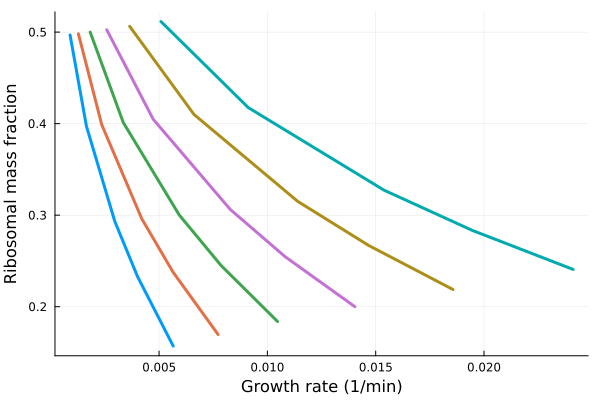

In [161]:
calc_rmf_abx(r, cr, ct, cm, cq, zmr, zmt, zmm, zmq, nr, Mref) = nr * (r + cr + ct + cm + cq + zmr + zmt + zmm + zmq) / Mref

ns_arr2 = [0.08,0.11541599,0.16651064,0.24022489,0.3466,0.5]
Cm_arr = [0, 2, 4, 8, 12]
params_abx_new = deepcopy(params_abx)

growth_rate_abx = []
rmf_abx = []
# for loop to simulate for each ns and Cm value
for ns_val in ns_arr2
    res_lam = []
    res_rmf = []
    params_abx_new[:ns] = ns_val
    for Cm_val in Cm_arr
        params_abx_new[:abx] = Cm_val
        prob_abx = ODEProblem(abx_growth_model, u0_abx, tspan, params_abx_new)
        sol_abx = solve(prob_abx, Rodas5()); 
        df = DataFrame(sol_abx)
        final_a = df[end, "a(t)"]
        final_cr = df[end, "cr(t)"]
        final_ct = df[end, "ct(t)"]
        final_cm = df[end, "cm(t)"]
        final_cq = df[end, "cq(t)"]
        growth = lam(params_abx_new[:gmax], final_a, params_abx_new[:Kgamma], final_cr, final_ct, final_cm, final_cq, params_abx_new[:Mref])
        
        final_r = df[end, "r(t)"]
        final_zmr = df[end, "zmr(t)"]
        final_zmt = df[end, "zmt(t)"]
        final_zmm = df[end, "zmm(t)"]
        final_zmq = df[end, "zmq(t)"]
        rmf_val = calc_rmf_abx(final_r, final_cr, final_ct, final_cm, final_cq, final_zmr, final_zmt, final_zmm, final_zmq, params_abx_new[:nr], params_abx_new[:Mref])
        
        push!(res_lam, growth)
        push!(res_rmf, rmf_val)
    end
    push!(growth_rate_abx, res_lam)
    push!(rmf_abx, res_rmf)
end

# plot the results
plot(growth_rate_abx, rmf_abx, lw=3, ylabel="Ribosomal mass fraction", xlabel="Growth rate (1/min)", legend=false)